<a href="https://colab.research.google.com/github/Hamsterrrrrrrrr/Class-Example/blob/main/smallproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import subprocess
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import linregress

# wk 1: leads 0-7 (7 days: L = 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5)
# wk 2: leads 7-14
# wk 3-4: leads 14-28
lead = (14, 28)

# Large India domain: 70E-90E, 5N-35N
# weekly June starts 1989-2010 (training)
# weekly June starts 2011-2018 (validation)
west = 70
east = 90
south = 5
north = 35
start_window = 'Jun'
training_years = (1989, 2010)
validation_years = (2011, 2018)

predictor_dataset = 'SOURCES/.Models/.SubX/.EMC/.GEFSv12_CPC/.hindcast/weekly/.pr/S/(0000%201%20Jan%20{first_year})/(0000%2031%20Dec%20{final_year})/RANGEEDGES/S/({start_window})/VALUES/Y/{south}/{north}/RANGE/X/{west}/{east}/RANGE/L/{lead_start}/{lead_end}/RANGEEDGES/%5BL%5D//keepgrids/average/SOURCES/.Models/.SubC/.EMC/.GEFSv12_CPC/.hindcast/.dc0018/.pr/Y/{south}/{north}/RANGE/X/{west}/{east}/RANGE/L/{lead_start}/{lead_end}/RANGEEDGES/%5BL%5Daverage/S/to366daysample/%5BYR%5Daverage/S/sampleDOY/sub/units/cvntos/(%20day-1)/append//units/exch/def/c%3A/0.001/(m3%20kg-1)/%3Ac/mul/(mm/day)/unitconvert//name/(anomaly)/def'

predictand_dataset = 'SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/Y/{south}/{north}/RANGE/X/{west}/{east}/RANGE'

predictor_url_template = f'https://iridl.ldeo.columbia.edu/{predictor_dataset}/L/removeGRID/data.nc'

predictand_url_template = f'https://iridl.ldeo.columbia.edu/{predictor_dataset}/L/S/add/0/RECHUNK//name//T/def/2/%7Bexch%5BL/S%5D//I/nchunk/NewIntegerGRID/replaceGRIDstream%7Drepeat/use_as_grid/{predictand_dataset}/%5BX/Y%5DregridLinear/T/(days%20since%201960-01-01)/streamgridunitconvert/dup/pentadAverage/pentadmean/%5BT%5D/regridLinear/sub/T/{{lead_end}}/{{lead_start}}/sub/runningAverage/T/2/index/.T/SAMPLE/nip//name/(anomaly)/def/data.nc'


def get_file(name, url_template, years, download):
    fname = f'download/{name}_{years[0]}-{years[1]}.nc'
    dset_url = url_template.format(
        first_year=years[0],
        final_year=years[1],
        lead_start=lead[0],
        lead_end=lead[1],
        start_window=start_window,
        west=west,
        east=east,
        south=south,
        north=north,
    )
    if download:
        print(dset_url)
        subprocess.call(['curl','-k',dset_url, '-o',fname])

    da = xr.open_dataset(fname)['anomaly']
    return da

def get_data(years, download):
    x = get_file('GEFS_pra', predictor_url_template, years, download)
    t = x['S'] + pd.Timedelta(days=(lead[0] + lead[1]) / 2)
    x = x.assign_coords(T=('S', t.values)).swap_dims(S='T')

    y = get_file('GEFS_CHIRPS_pra', predictand_url_template, years, download)

    assert (x['T'].values == y['T'].values).all()

    return x, y

def get_training(download=True):
    return get_data(training_years, download)


def get_validation(download=True):
    return get_data(validation_years, download)

def climo_predict(x):
    '''Predict function that always predicts climatological conditions,
    i.e. equal probabilities for all three terciles.'''
    x = x.mean('M')
    fcst = xr.concat(
        [xr.full_like(x, 1/3)] * 3,
        'category'
    ).where(x.notnull())
    return fcst

def rps(obs, fcst):
    # Put categorical observations in the shape of a forecast where
    # the probability of one tercile is 1 and the others are 0.
    obs_reshaped = xr.concat(
        [
            (obs == -1).assign_coords(category='below'),
            (obs == 0).assign_coords(category='normal'),
            (obs == 1).assign_coords(category='above'),
        ],
        'category'
    ).where(obs.notnull())
    return xskillscore.rps(obs_reshaped, fcst, dim='T', category_edges=None, input_distributions='p')

def rpss(reference, forecast, observations):
    return 1 - rps(observations, forecast) / rps(observations, reference)

def make_tercile_labeler(observations):
    edges = observations.quantile(q=[1/3, 2/3], dim='T')
    def labeler(y):
        return (
            xr.where(y < edges.isel(quantile=0), -1, 0) +
            xr.where(y > edges.isel(quantile=1), 1, 0)
        ).where(y.notnull())
    return labeler

In [ ]:
download=True
!mkdir -p download
xt, yt = get_training(download)

https://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.EMC/.GEFSv12_CPC/.hindcast/weekly/.pr/S/(0000%201%20Jan%201989)/(0000%2031%20Dec%202010)/RANGEEDGES/S/(Jun)/VALUES/Y/5/35/RANGE/X/70/90/RANGE/L/14/28/RANGEEDGES/%5BL%5D//keepgrids/average/SOURCES/.Models/.SubC/.EMC/.GEFSv12_CPC/.hindcast/.dc0018/.pr/Y/5/35/RANGE/X/70/90/RANGE/L/14/28/RANGEEDGES/%5BL%5Daverage/S/to366daysample/%5BYR%5Daverage/S/sampleDOY/sub/units/cvntos/(%20day-1)/append//units/exch/def/c%3A/0.001/(m3%20kg-1)/%3Ac/mul/(mm/day)/unitconvert//name/(anomaly)/def/L/removeGRID/data.nc
https://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.EMC/.GEFSv12_CPC/.hindcast/weekly/.pr/S/(0000%201%20Jan%201989)/(0000%2031%20Dec%202010)/RANGEEDGES/S/(Jun)/VALUES/Y/5/35/RANGE/X/70/90/RANGE/L/14/28/RANGEEDGES/%5BL%5D//keepgrids/average/SOURCES/.Models/.SubC/.EMC/.GEFSv12_CPC/.hindcast/.dc0018/.pr/Y/5/35/RANGE/X/70/90/RANGE/L/14/28/RANGEEDGES/%5BL%5Daverage/S/to366daysample/%5BYR%5Daverage/S/sampleDOY/sub/units/cvntos/(%20day-1)/appen

In [ ]:
print(xt.shape,yt.shape)

(11, 97, 31, 21) (97, 31, 21)


In [ ]:
print(xt)


<xarray.DataArray 'anomaly' (M: 11, T: 97, Y: 31, X: 21)>
[694617 values with dtype=float32]
Coordinates:
  * M        (M) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * Y        (Y) float32 5.0 6.0 7.0 8.0 9.0 10.0 ... 31.0 32.0 33.0 34.0 35.0
    S        (T) datetime64[ns] 1989-06-07 1989-06-14 ... 2010-06-23 2010-06-30
  * X        (X) float32 70.0 71.0 72.0 73.0 74.0 ... 86.0 87.0 88.0 89.0 90.0
  * T        (T) datetime64[ns] 1989-06-28 1989-07-05 ... 2010-07-14 2010-07-21
Attributes:
    pointwidth:          0.0
    long_name:           Total Precipitation
    level_type:          surface
    standard_name:       precipitation_flux
    file_missing_value:  9.96921e+36
    history:             [[(mean [ Models SubC EMC GEFSv12 hindcast weekly pr...
    units:               mm/day


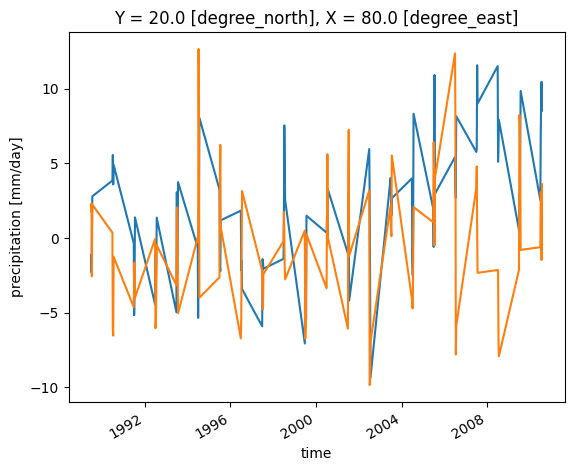

In [ ]:
X,Y=10,15
xt.isel(X=X,Y=Y).mean('M').plot()
yt.isel(X=X,Y=Y).plot()

In [ ]:
# Assuming latitude (Y) ranges from 70 to 90 (inclusive) and longitude (X) from 5 to 35 (inclusive)
latitude = np.linspace(70, 90, 21)  # Creates 31 evenly spaced points in the range 70 to 90
longitude = np.linspace(5, 35, 31)  # Creates 21 evenly spaced points in the range 5 to 35

# Initialize containers for storing results
slopes = xr.DataArray(data=np.zeros((31, 21)), dims=("Y", "X"), coords={"Y": longitude, "X": latitude})
intercepts = xr.DataArray(data=np.zeros((31, 21)), dims=("Y", "X"), coords={"Y": longitude, "X": latitude})

for x in range(21):  # X dimension size is 21
    for y in range(31):  # Y dimension size is 31
        # Select data for current location and average over 'M' for xt
        xt_loc = xt.isel(X=x, Y=y).mean('M')
        yt_loc = yt.isel(X=x, Y=y)

        # Convert to numpy arrays
        x_np = xt_loc.values
        y_np = yt_loc.values

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x_np, y_np)

        # Store the results
        slopes[y, x] = slope
        intercepts[y, x] = intercept


In [ ]:
def plot_data_array(da, title, cmap='viridis'):
    """
    Plots an xarray DataArray with a title and color map.

    Parameters:
    - da: xarray.DataArray to plot.
    - title: Title for the plot.
    - cmap: Color map to use for plotting.
    """
    plt.figure(figsize=(10, 6))
    da.plot(cmap=cmap)
    plt.title(title)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()

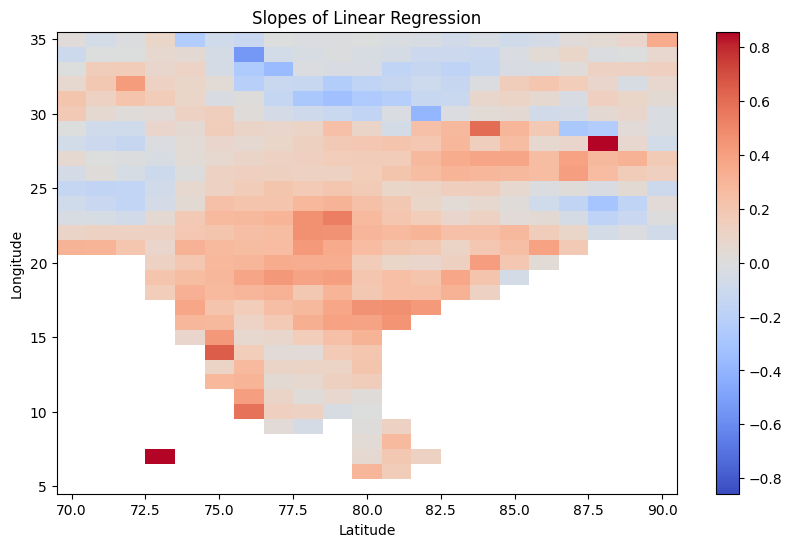

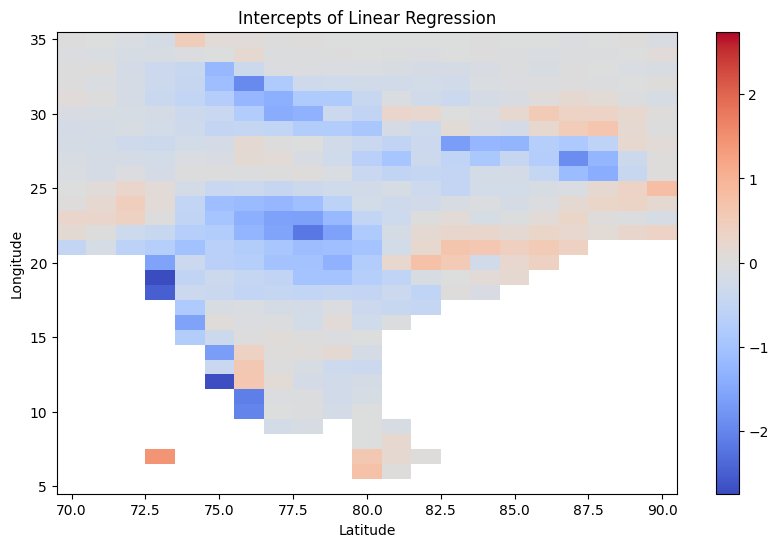

In [ ]:
plot_data_array(slopes, 'Slopes of Linear Regression', cmap='coolwarm')
plot_data_array(intercepts, 'Intercepts of Linear Regression', cmap='coolwarm')